This scritp aims to solve the Grad-Shafranov equation modelling the plasma equilibrium in an axisymmetrical (cylindrical) system.
It shall constitute the benchmark or miniature code for the actual project behind, which goal is to develop a module for ALYA (BSC-Marenostrum)
computing the plasma equilibrium.

READ INPUT FILES...
     -> READ MESH DATA FILES...Done!
     -> READ EQUILI DATA FILE...Done!
Done!
INITIALIZATION...
     -> INITIALISE LEVEL-SET...Done!
     -> INITIALISE ELEMENTS...Done!
     -> CLASSIFY ELEMENTS...Done!
     -> APPROXIMATE VACUUM VESSEL FIRST WALL...Done!
     -> APPROXIMATE PLASMA/VACUUM INTERFACE...Done!
     -> COMPUTE NUMERICAL INTEGRATION QUADRATURES...Done!
     -> INITIALISE UNKNOWN VECTORS AND COMPUTE INITIAL GUESS...
         -> COMPUTE INITIAL GUESS FOR PHI_NORM...Done!
Total plasma current normalization factor =  0.019972190909353215
Normalised total plasma current =  -15000000.0
         -> COMPUTE INITIAL VACUUM VESSEL FIRST WALL VALUES PHI_B...Done!
     Done!
Done!


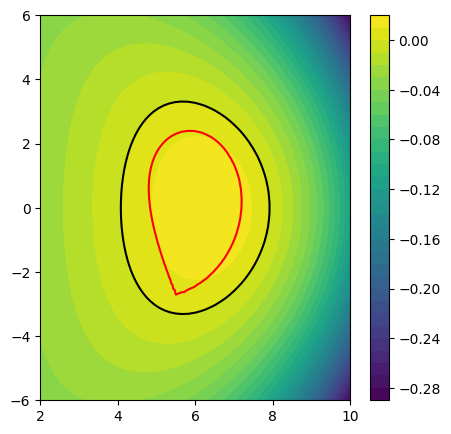

START ITERATION...
OUTER ITERATION = 1 , INNER ITERATION = 1
Total plasma current normalization factor =  1
Normalised total plasma current =  -751044292.9411075
     Integrate over non-cut elements...Done!
     Integrate over cut-elements subelements...Done!
     Integrate along cut-elements interface edges...Done!
LOCAL EXTREMUM AT  [6.01886539 0.11737593]  (ELEMENT  722 ) WITH VALUE PHI_0 =  [10.37519701]
SADDLE POINT AT  [ 4.65734477 -3.95596632]  (ELEMENT  326 ) WITH VALUE PHI_X =  [-13.79403124]


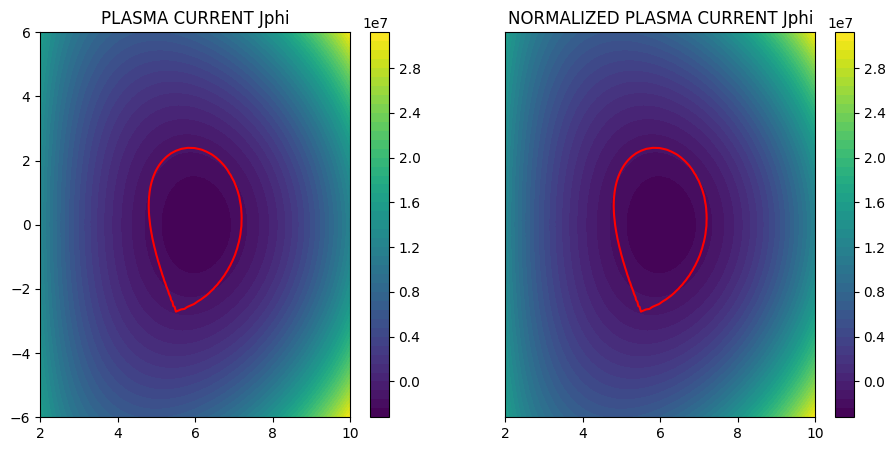

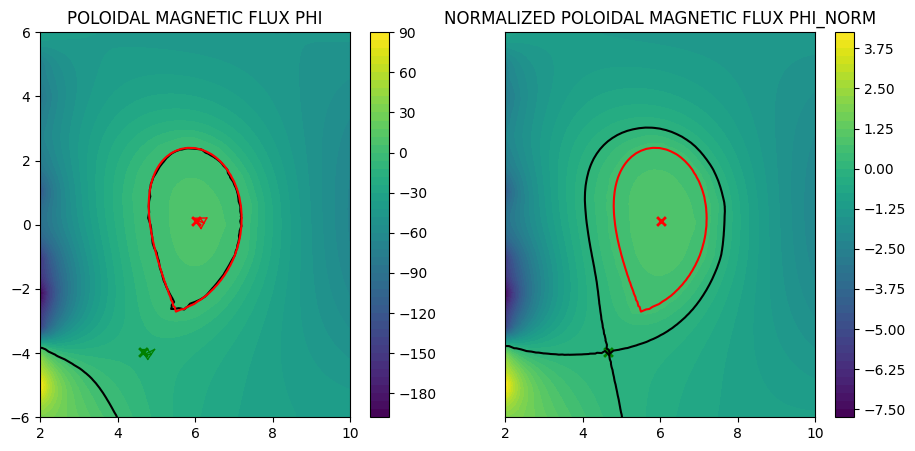

Internal iteration =  1 , PHI_NORM residu =  0.9721489978876791
 
OUTER ITERATION = 1 , INNER ITERATION = 2
Total plasma current normalization factor =  1
Normalised total plasma current =  -58796224185.05895
     Integrate over non-cut elements...Done!
     Integrate over cut-elements subelements...Done!
     Integrate along cut-elements interface edges...Done!
LOCAL EXTREMUM AT  [5.7909664  0.09668351]  (ELEMENT  733 ) WITH VALUE PHI_0 =  [1066.63929655]


Exception: SADDLE POINT NOT FOUND

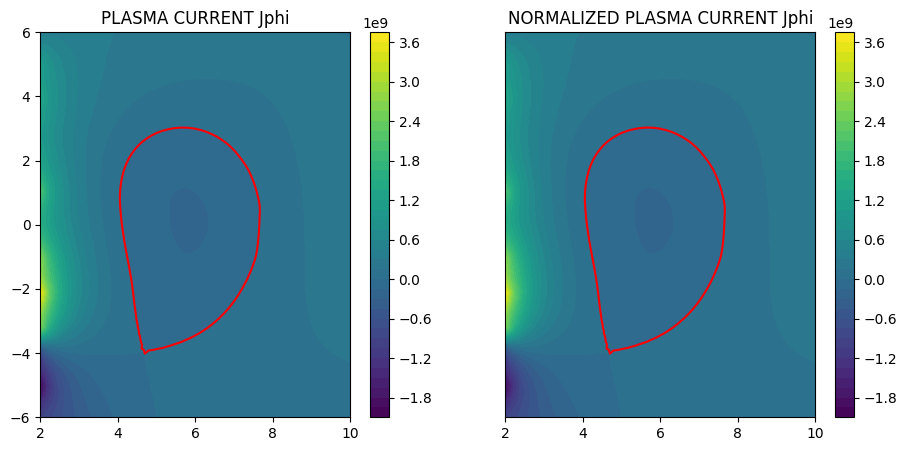

In [8]:
import sys
sys.path.append('/home/elmanyer/Documents/BSC/MasterThesis/Code/EQUILI_PY/')

from src.GradShafranovCutFEM import *

### LOCATION OF FOLDERS
folder_MESHES = '/home/elmanyer/Documents/BSC/MasterThesis/Code/EQUILI_PY/MESHES/'   # MESHES
folder_CASES = '/home/elmanyer/Documents/BSC/MasterThesis/Code/EQUILI_PY/CASES/'     # CASES

### SELECT MESH FOLDER...
#MESH = 'TS-UNSTRUCTURED_FINE'
###### LINEAR TRIANGULAR ELEMENT MESH
#MESH = 'TS-CUTFEM-TRI03-COARSE'
#MESH = 'TS-CUTFEM-TRI03-MEDIUM'
#MESH = 'TS-CUTFEM-TRI03-FINE'
###### QUADRATIC TRIANGULAR ELEMENT MESH
#MESH = 'TS-CUTFEM-TRI06-COARSE'
#MESH = 'TS-CUTFEM-TRI06-MEDIUM'
MESH = 'TS-CUTFEM-TRI06-FINE'
###### LINEAR QUADRILATERAL ELEMENT MESH
#MESH = 'TS-CUTFEM-QUA04-COARSE'
#MESH = 'TS-CUTFEM-QUA04-MEDIUM'
#MESH = 'TS-CUTFEM-QUA04-FINE'
###### QUADRATIC QUADRILATERAL ELEMENT MESH
#MESH = 'TS-CUTFEM-QUA09-COARSE'
#MESH = 'TS-CUTFEM-QUA09-MEDIUM'
#MESH = 'TS-CUTFEM-QUA09-FINE'

# ... WITH MESH ELEMENTS:
ElementType = 1     # Element type -> 1: TRIANGLE  ; 2: QUADRILATERAL
ElementOrder = 2    # Element order -> 1: LINEAR  ; 2: QUADRATIC ; 3: CUBIC ...

### SELECT SOLUTION CASE FILE:
#CASE = 'TS-FREE-F4E-LINEAR'          # FREE PLASMA BOUNDARY WITH F4E PLASMA REGION GEOMETRY AND LINEAR PLASMA CURRENT
#CASE = 'TS-FREE-F4E-NONLINEAR'       # FREE PLASMA BOUNDARY WITH F4E PLASMA REGION GEOMETRY AND NONLINEAR PLASMA CURRENT MODEL
#CASE = 'TS-FREE-F4E-PROFILES'        # FREE PLASMA BOUNDARY WITH F4E PLASMA REGION GEOMETRY AND PLASMA CURRENT MODEL BASED ON PROFILES FOR PRESSURE AND TOROIDAL FIELD
#CASE = 'TS-FREE-F4E-PROFILES_2'        
CASE = 'TS-FREE-F4E-PROFILES_3'
#CASE = 'TS-FREE-F4E-LINEAR-1W'       # FREE PLASMA BOUNDARY WITH F4E PLASMA REGION GEOMETRY, LINEAR PLASMA CURRENT AND FIRST WALL VACUUM VESSEL GEOMETRY  
#CASE = 'TS-FREE-F4E-PROFILES-1W'     # FREE PLASMA BOUNDARY WITH F4E PLASMA REGION GEOMETRY, PLASMA CURRENT MODEL BASED ON PROFILES FOR PRESSURE AND TOROIDAL FIELD AND FIRST WALL VACUUM VESSEL GEOMETRY  

##############################################################

# DECLARE OBJECT PROBLEM 
Problem = GradShafranovCutFEM(folder_MESHES+MESH,folder_CASES+CASE,ElementType,ElementOrder)
Problem.EQUILI()

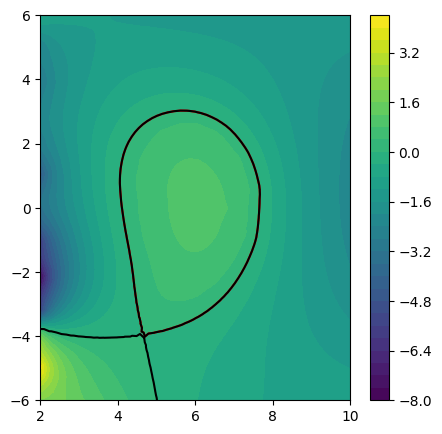

In [9]:
Problem.PlotSolution(Problem.PHI_NORM[:,1])

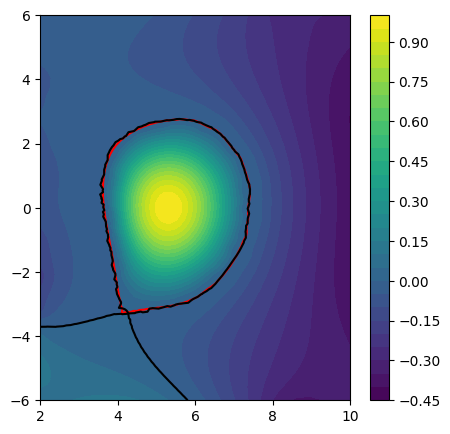

In [7]:
Problem.PlotSolution(Problem.PHI_NORM[:,1])

In [ ]:
np.save('PSIconverged.npy', Problem.PHI_CONV)
np.save('MeshXcoords.npy', Problem.X[:,0])
np.save('MeshYcoords.npy', Problem.X[:,1])
np.save('EquilibriumLevelSet.npy',Problem.PlasmaBoundLevSet)

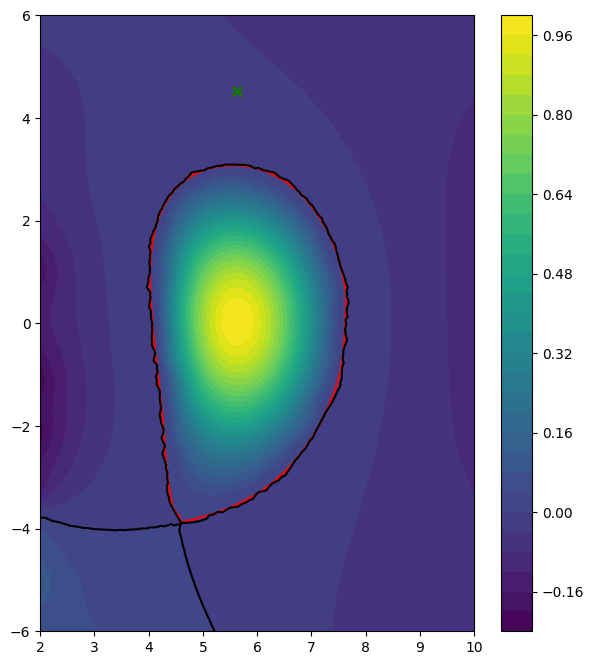

In [ ]:
# TRY TO GET THE PLASMA SHAPE RIGHT

self = Problem
phi = self.PHI_NORM[:,0]

if len(np.shape(phi)) == 2:
    phi = phi[:,0]
fig, axs = plt.subplots(1, 1, figsize=(7,8))
axs.set_xlim(self.Xmin,self.Xmax)
axs.set_ylim(self.Ymin,self.Ymax)
a = axs.tricontourf(self.X[:,0],self.X[:,1], phi, levels=30)
axs.tricontour(self.X[:,0],self.X[:,1], self.PlasmaBoundLevSet, levels=[0], colors = 'red')
contour = axs.tricontour(self.X[:,0],self.X[:,1], phi, levels=[0], colors = 'black')
plt.colorbar(a, ax=axs)
## PLOT LOCATION OF CRITICAL POINTS 
# LOCAL EXTREMUM
axs.scatter(self.Xcrit[0,0],self.Xcrit[0,1],marker = 'x',color='red', s = 40, linewidths = 2)
# SADDLE POINT
axs.scatter(self.Xcrit[1,0],self.Xcrit[1,1],marker = 'x',color='green', s = 40, linewidths = 2)
plt.show()

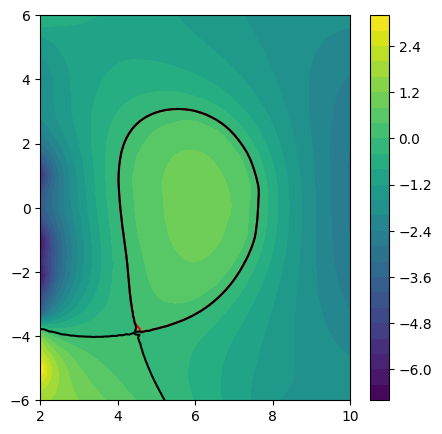

In [ ]:
Problem.PlotSolution(Problem.PHI_NORM_ALL[:,1])

In [ ]:
Problem.PHI_crit_ALL[1,:,1]

array([-22.72964697,   4.49758798,  -3.89735473])

In [ ]:
np.save('PSI_norm.npy', Problem.PHI_NORM_ALL[:,1])
np.save('Meshcoords.npy', Problem.X)
np.save('Xcrit.npy', Problem.PHI_crit_ALL[1,:,1])

[]

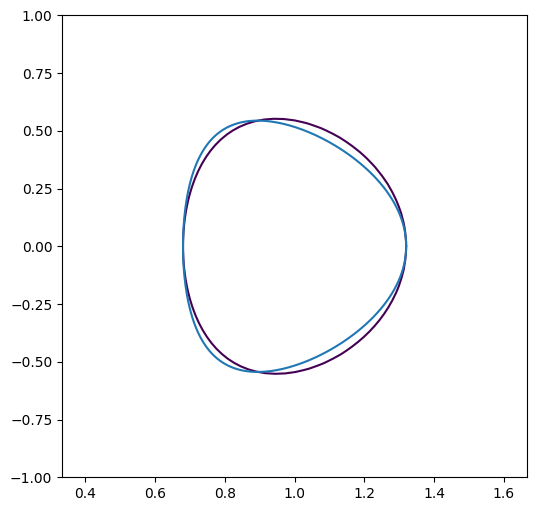

In [ ]:
# VERIFY D-SHAPE PARAMETRISATION 

self = Problem

Xstar = self.X/self.R0
Dshape0 = np.zeros([self.Nn])
for i in range(self.Nn):
    Dshape0[i] = (Xstar[i,0]**4)/8 + self.coeffs1W[0] + self.coeffs1W[1]*Xstar[i,0]**2 + self.coeffs1W[2]*(Xstar[i,0]**4-4*Xstar[i,0]**2*Xstar[i,1]**2)

n = 360
theta = np.linspace(0,2*np.pi,n)
xb = np.zeros([n])
yb = np.zeros([n])
alpha = np.arcsin(self.delta)
for i in range(n):
    xb[i] = 1+self.epsilon*np.cos(theta[i]+alpha*np.sin(theta[i]))
    yb[i] = self.epsilon*self.kappa*np.sin(theta[i])

fig, axs = plt.subplots(1, 1, figsize=(6,6))
axs.tricontour(Xstar[:,0],Xstar[:,1],Dshape0,levels=[0])
axs.plot(xb,yb)
plt.plot()
